[View on GitHub](https://github.com/csc-training/sscc-cp2k)

# Proton transfer simulations with CP2K

## Part 4: Ab initio molecular dynamics simulation of 2-formylcyclohexanone in aqueous solution

Standard classical MD simulations are unable to describe chemical reactions such as proton transfer. In ab initio molecular dynamics (AIMD) simulations the forces are calculated at each time step from first principles instead of a parametrized empirical force field. Atoms are thus free to move however they please, making bond making and breaking possible. AIMD simulations are very heavy and are typically run only for about ~100 ps. It is therefore typically not possible to observe chemical reactions without applying some external bias on the system. In the present case, however, the proton transfer barrier is so low (about the size of the thermal energy) that we can see and sample it.

### Step 4.1: Preparing the system for AIMD simulation

**Start by copying the IS coordinate file to the current working directory:**

In [ ]:
!cp ../Part-1-NEB/enol-is.xyz ./enol.xyz

Before starting the AIMD simulation, we need to solvate the system, i.e. fill the box with water molecules. GROMACS has good tools for this, but we need to first convert the `.xyz` file to another format that GROMACS understands, e.g. `.gro`. This conversion can be done using the OpenBabel tool. **Perform the conversion to `.gro`, solvation and conversion back to `.xyz` by running the cell below:**

In [ ]:
%%bash
obabel enol.xyz -O enol.gro
gmx solvate -cp enol.gro -cs spc216.gro -o enol-solv.gro -box 1.5 1.5 1.5
obabel enol-solv.gro -O enol-solv.xyz

**Have a look at the solvated system:**

In [12]:
import py3Dmol

with open("enol-solv.xyz", "r") as f:
    enol = f.read()

view = py3Dmol.view(height=400, width=800)
view.addModel(enol)
view.setStyle({'sphere':{'scale':0.30},'stick':{'radius':0.25}})
view.addUnitCell()
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Step 4.2: Prepare the input file and submit the calculation

**Inspect the input file and fix all occurrences of `FIXME` based on that:**

* Run type is `MD`
* Timestep is `0.5` fs and we'll simulate the `NVT` ensemble (particle number, volume and temperature are kept constant)
* PBE has a tendency to "overstructure" water (it is too ice-like). To mitigate this, we'll use a simulation temperature of `348.15` K (room temperature + 50 K)

Once fixed, write the input to a file `aimd.inp` by running the cell.

In [13]:
%%writefile aimd.inp
&GLOBAL
  PROJECT enol-aimd                             ! Project name, gets prepended to all output files
  RUN_TYPE FIXME                                ! Type of calculation
  PRINT_LEVEL LOW                               ! Low verbosity
&END GLOBAL

&FORCE_EVAL                                     ! Include DFT and system settings
  &DFT
    BASIS_SET_FILE_NAME BASIS_MOLOPT
    &QS
      EPS_DEFAULT 1.0E-12                       ! Sets convergence criteria so that energy should be accurate up to this value
    &END QS
    &POISSON                                    ! How to deal with electrostatics
      PERIODIC XYZ                              ! System is periodic
      POISSON_SOLVER PERIODIC                   ! Solver for periodic systems
    &END POISSON
    &SCF
      SCF_GUESS ATOMIC                          ! Initial density guess is a simple superposition of atomic charge densities
      EPS_SCF 1.0E-6                            ! Energy convergence criteria (atomic units)
      &OT                                       ! Use orbital transformation method instead of brute-force diagonalization
        ALGORITHM IRAC                          ! OT algorithm
        MINIMIZER DIIS                          ! Minimization algorithm
        PRECONDITIONER FULL_ALL                 ! Preconditioner for the minimizer
      &END OT
      MAX_SCF 20                                ! Maximum number of SCF steps before rebuilding preconditioner
      &OUTER_SCF ON
        EPS_SCF 1.0E-6                          ! Outer loop energy convergence criteria (atomic units)
        MAX_SCF 12                              ! Maximum number of preconditioner rebuilds before terminating
      &END OUTER_SCF
      &PRINT
        &RESTART
          BACKUP_COPIES 0                       ! Avoid excessive printing of restart files
        &END RESTART
      &END PRINT
    &END SCF
    &XC
      &XC_FUNCTIONAL PBE                        ! Exchange-correlation funtional to use
      &END XC_FUNCTIONAL
    &END XC
  &END DFT
  &SUBSYS
    &CELL
      PERIODIC XYZ                              ! System is periodic
      ABC 15.0 15.0 15.0                        ! Dimensions of the simulation cell in angstroms
    &END CELL
    &TOPOLOGY                                   ! Specify input coordinate format and filename
      COORD_FILE_FORMAT XYZ
      COORD_FILE_NAME enol-solv.xyz
    &END TOPOLOGY
    &KIND H                                     ! Basis sets and pseudopotential for hydrogen
      BASIS_SET DZVP-MOLOPT-SR-GTH
      POTENTIAL GTH-PBE-q1
    &END KIND
    &KIND C                                     ! Basis sets and pseudopotential for carbon
      BASIS_SET DZVP-MOLOPT-SR-GTH
      POTENTIAL GTH-PBE-q4
    &END KIND
    &KIND O                                     ! Basis sets and pseudopotential for oxygen
      BASIS_SET DZVP-MOLOPT-SR-GTH
      POTENTIAL GTH-PBE-q6
    &END KIND
  &END SUBSYS
&END FORCE_EVAL

&MOTION
  &MD
    ENSEMBLE FIXME                              ! Thermodynamic ensemble
    STEPS 200                                   ! How many MD steps to run
    TIMESTEP FIXME                              ! Timestep in femtoseconds
    &THERMOSTAT                                 ! Thermostat settings
      TYPE CSVR
      &CSVR
        TIMECON 50                              ! Low value for equilibration
      &END CSVR
    &END THERMOSTAT
    TEMPERATURE FIXME                           ! Simulation temperature in K
  &END MD
  &PRINT                                        ! We don't need restarts in this case
    &RESTART OFF
    &END RESTART
    &RESTART_HISTORY OFF
    &END RESTART_HISTORY
  &END PRINT
&END MOTION

Overwriting aimd.inp


**Next, write the following simple batch job script to a file by running the cell.** We'll again request two full Puhti nodes (40 CPU cores each).

In [14]:
%%writefile job.sh
#!/bin/bash
#SBATCH --time=00:30:00
#SBATCH --reservation=sscc_thu_large
#SBATCH --partition=large
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=40
#SBATCH --account=project_2006657

module purge
module load intel-oneapi-compilers-classic/2021.6.0
module load intel-oneapi-mpi/2021.6.0
module load cp2k/2024.1

srun cp2k.psmp aimd.inp

Overwriting job.sh


**Run the calculation as a batch job by executing the cell below.** Note, before running `sbatch`, we unset all Slurm environment variables as we are submitting a batch job from another Slurm job (this notebook that we're currently running).

In [ ]:
%%bash
unset ${!SLURM@}; sbatch job.sh

Even though we'll run the simulation for just 200 steps (100 fs), it will take more than 20 minutes. You may monitor the queue using `squeue` command:

In [15]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          21204271 interacti sys/dash rkronber  R    8:02:00      1 r07c06


### Step 4.3: Analysis

100 fs is way too little for any meaningful results. **Thus, download a longer pre-simulated 50 ps (100 000 steps) trajectory of the same system.** Note that the water molecules have been removed afterwards from the coordinate file in order to decrease the file size.

In [ ]:
!wget https://a3s.fi/CSC_training/enol-aimd-nowater.xyz

Let's analyze the proton transfer energy profile based on the sampled dynamics! To this end, we will define a *reaction coordinate* that quantifies the progress of the reaction:

$$q=d_\mathrm{O_a H}-d_\mathrm{O_b H}$$

where $d_\mathrm{O_a H}$ is the distance between the proton and the oxygen attached directly to the cyclohexane ring and $d_\mathrm{O_b H}$ os the distance between the proton and the oxygen on the aldehyde side chain. In other words, when $q<0$, the proton is closer to the cyclohexane oxygen and when $q>0$ the proton is closer to the side chain oxygen.

By sampling the value of the reaction coordinate along the trajectory, the free energy $A$ can be calculated as

$$A(q)=-k_\mathrm{B}T\ln P(q)$$

where $P(q)$ is the probability density of the reaction coordinate.

**Start by reading the trajectory into memory:**

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# Read input trajectory
trj = read("enol-aimd-nowater.xyz", index=':')

Next, we'll calculate the value of the proton transfer coordinate over the trajectory and bin the values to obtain the probability density. The free energy is then calculated from $P(q)$ as detailed above. **Do this and plot all the results by running the cell below:**

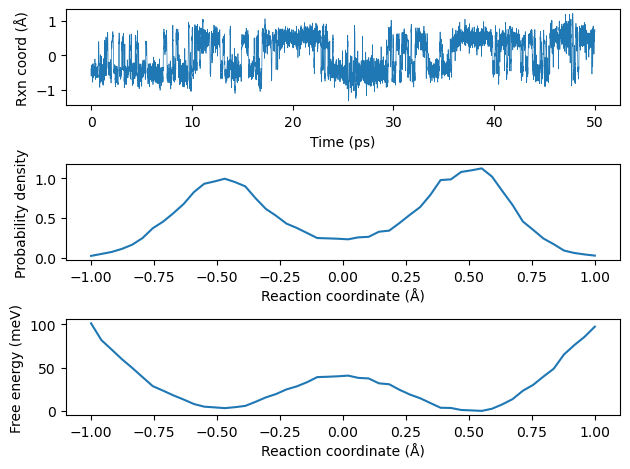

In [45]:
# Thermal energy at room temperature in meV
kT = 25.7

# Initialize array for reaction coordinate
rc = np.zeros(len(trj))

# Loop over trajectory, relevant atoms indices are hard-coded
for i, frame in enumerate(trj):
    rc[i] = frame.get_distance(10, 14)-frame.get_distance(12,14)

# Calculate probability density
b = 50
hist, _ = np.histogram(rc, bins=b, range=(-1, 1), density=True)

# Compute free energy and shift minimum to zero
energy = -kT*np.log(hist/np.amax(hist))

# Assign x-axes
time = np.arange(len(rc))/2000
rxn = np.linspace(-1, 1, b)

# Plot
_, ax = plt.subplots(3, 1)
    
# Time evolution of the reaction coordinate
ax[0].plot(time, rc, lw=0.5)
ax[0].set_xlabel('Time (ps)')
ax[0].set_ylabel('Rxn coord (Å)')

# Probability density of the reaction coordinate
ax[1].plot(rxn, hist)
ax[1].set_xlabel('Reaction coordinate (Å)')
ax[1].set_ylabel('Probability density')

# Helmholtz free energy profile
ax[2].plot(rxn, energy)
ax[2].set_xlabel('Reaction coordinate (Å)')
ax[2].set_ylabel('Free energy (meV)')

plt.tight_layout()
plt.show()

* What can you say about the free energy profile? Does the reaction free energy and barrier differ from the static NEB results? Why?

## Conclusions and how to improve

The aim of this hands-on was to introduce CP2K and how to study simple low-barrier chemical reactions with NEB and AIMD. NEB is a useful method to study reactions that occur in a rather static environment (e.g. surface processes or reactions in vacuum). However, when reactions happen in solution or at an interface between a solid and a liquid, dynamics of the environment may be important to include through e.g. AIMD. However, unbiased AIMD simulations are useful only if the reaction has a very low barrier like here. Typically, one needs to introduce a bias to drive the reaction forward. Such methods fall into the category of enhanced sampling techniques, including e.g. umbrella sampling, thermodynamic integration, metadynamics and adaptive weight histogram methods.

* Thinking about the current hands-on, can you list some things that could have been done better?
  <details><summary>Spoilers!</summary>
      <ul>
          <li>
              Dispersion (van der Waals) interactions are completely missing, these are needed to model water accurately
          </li>
          <li>
              NEB not fully converged
          </li>
          <li>
              Much more AIMD statistics needed
          </li>
          <li>
              Converging cutoff for the real-space integration grids, basis set, functionals, etc.
          </li>
          <li>
              Nuclear quantum effects
          </li>
      </ul>
  </details>